## 9. Example Project
###  Sample Solutions 

Copy and past all neccessary functions from lesson notebook

In [1]:
using CSV, DataFrames
using GLMakie,ColorSchemes, Random

In [2]:
function create_objects(Gridsize, Cell_number)
    Grid = zeros(Int64, Gridsize, Gridsize)
    Cell_list = Vector{Vector{Int64}}(undef,0)
    return Grid, Cell_list
end

function populate_sys!(Grid, Cell_list, Starting_config,Gridsize, Cell_number) 
    if Starting_config == "random"
        i = 1
        while i <= Cell_number
            x = rand(1:Gridsize)
            y = rand(1:Gridsize)
            if Grid[x,y] == 0 
                Grid[x,y] = i
                push!(Cell_list,[x,y])
                i += 1
            end
        end
    end
    if Starting_config == "square"
        #calculate edge length of square of cells
        Edge_length = round(Int64,sqrt(Cell_number))
        # round cell_number to closest square number
        Cell_number = Edge_length^2
        #calculate starting x and y value of corner of square on grid
        X_corner = round(Int64,Gridsize/2-Edge_length/2)
        Y_corner = round(Int64,Gridsize/2-Edge_length/2)
        #all the rounding is needed to get to discrete grid points
        i = 1
        for x = 1:Edge_length
            for y = 1:Edge_length
                Grid[X_corner+x, Y_corner+y] = i
                push!(Cell_list,[X_corner+x,Y_corner+y])
                i += 1
            end
        end
    end
    #return everything that could have changed
    return Grid, Cell_list, Cell_number
end

populate_sys! (generic function with 1 method)

In [3]:
function plot_sim(Cell_list, Gridsize)
    # make plot look nicer in black ; )
    set_theme!(theme_black())

    # using array comprehensions to create positions array of x and y
    x = [i[1] for i in Cell_list]
    y = [i[2] for i in Cell_list]
    # calculate the distance r for every cell fromm the center
    
    ## explain better 
    r = (((x.-Gridsize/2).^2+(y.-Gridsize/2).^2).^(1/2))

    Fig1 = Figure(resolution = (1000,1000))
    Ax1 =Axis(Fig1[1,1],title = "Startconfig",titlesize = 35)
    xlims!(Ax1,0,Gridsize)
    ylims!(Ax1,0,Gridsize)
    # using the distance r together with a colormap to give the cells different colors
    Scatty = scatter!(Ax1,x,y,color = r,colormap = :dense,label = "particle",marker = :circle,markersize = 8)

    return Fig1, Ax1 , Scatty
end

plot_sim (generic function with 1 method)

In [4]:
function update_sys(Grid, Cell_list, Gridsize,Timesteps)
    Cell_list_alltime =  Vector{Vector{Vector{Int64}}}(undef,0)           # super cell list which contains one cell_list per timestep 
    mov_vec = [[0,1],[0,-1],[1,0],[-1,0],[1,1],[-1,-1],[-1,1],[1,-1]]     #possible movement vectors to the next gridpoint
    sequence_vec = collect(1:8)                                           # sequence_vec is used to acess the mov_vec
    
    
    Cell_list_copy = deepcopy(Cell_list)                                  # make real copy (no reference) of Cell_list and push it into cell_list altime 
    push!(Cell_list_alltime,Cell_list_copy)
    for t = 1:Timesteps
        for (j,Cell) in  enumerate(Cell_list)
            shuffle!(sequence_vec)                                        # use shuffle function from random to esure random movement of particles
            for sque in sequence_vec
                x_next = Cell[1] + mov_vec[sque][1]
                y_next = Cell[2] + mov_vec[sque][2]
                
                if x_next >= 1 && x_next <= Gridsize && y_next >= 1 && y_next <= Gridsize    # check if gridpoint is out of bounds of grid
                    if Grid[x_next,y_next] == 0 && Grid[Cell[1],Cell[2]] != 0                # check if target gridpoint is empty and sanity check if cell exists on previous gridpoint
                        Grid[Cell[1],Cell[2]] = 0 
                        Grid[x_next,y_next]  = j 
                        
                        Cell[1] = x_next
                        Cell[2] = y_next
                        break
                    end
                end
            end
        end
        Cell_list_copy = deepcopy(Cell_list)                                   # creating copy of cell list in order to avoid a pass by refernce. 
        push!(Cell_list_alltime,Cell_list_copy)
    end
    return(Cell_list_alltime)
end

update_sys (generic function with 1 method)

In [5]:
function convert_to_DF(cell_list_alltime)
    cell_number = length(cell_list_alltime[1])
    Data = DataFrame(timestep = ones(Int64,cell_number),id= collect(1:cell_number),
        x = [i[1] for i in cell_list_alltime[1]],y = [i[2] for i in cell_list_alltime[1]])
    for j in 2:length(cell_list_alltime)
        append!(Data,DataFrame(timestep = ones(Int64,cell_number).*j,id= collect(1:cell_number),
                x = [i[1] for i in cell_list_alltime[j]],y = [i[2] for i in cell_list_alltime[j]]))
    end
    return Data
end

function save_settings(Gridsize,Cell_number,Timesteps,Starting_config)
    settings = Dict("gridsize" => Gridsize, "cell_number" => Cell_number, 
        "timesteps" =>Timesteps, "starting_config" => Starting_config)
    open("settings.txt","w") do file
        print(file,settings)
    end 
end

save_settings (generic function with 1 method)

In [6]:
function animation_2D(Data_gr,Gridsize) 
    t = Observable(1)
    x = @lift(Data_gr[$t].:x)
    y = @lift(Data_gr[$t].:y)
    r = @lift((($x.-Gridsize/2).^2+($y.-Gridsize/2).^2).^(1/2))
    titel = @lift(string($t))

    set_theme!(theme_black())

    fig6 = Figure(resolution = (1000,1000))
    ax6 =Axis(fig6[1,1],title = @lift("timestep : $(round(Int64,$t))"),titlesize = 35)
    xlims!(ax6,0,Gridsize)
    ylims!(ax6,0,Gridsize)
    scatty6 = scatter!(ax6,x,y,color = r,colormap = :dense,label = "particle",marker = :circle,markersize = 15)

    #hidedecorations!(ax6)
    axislegend(ax6)
    display(fig6)
    return t,fig6
end

function animation_3D(Data_gr,Gridsize) 
    # make sure that camera flight is not too fast
    if length(Data_gr) >= 1000
        len = length(Data_gr)
    else
        len = 1000
    end
    t = Observable(1)
    
    x = @lift(Data_gr[$t].:x)
    y = @lift(Data_gr[$t].:y)
    r = @lift((($x.-Gridsize/2).^2+($y.-Gridsize/2).^2).^(1/2))
    titel = @lift(string($t))
    # define the camara angle
    elevations = range(start = -2π,stop = 2π, length = len)
    azimuths = range(start = 0,stop = 2π, length = len)
    z = zeros(length(Data_gr[1].:x))
    set_theme!(theme_black())

    fig7 = Figure(resolution = (2000,2000))
    ax7 =Axis3(fig7[1,1],
        title = @lift("timestep : $(round(Int64,$t))"),
        elevation =@lift(elevations[$t])  , azimuth = @lift(azimuths[$t]),
        viewmode = :fit,
        titlesize = 35,protrusions = (0, 0, 0, 40)
        )   

    xlims!(ax7,0,Gridsize)
    ylims!(ax7,0,Gridsize)
    zlims!(-Gridsize/2,Gridsize/2)

    scatty7 = scatty = meshscatter!(ax7,x,y,z,markersize = 2.5,color = r,
        colormap = :diverging_gkr_60_10_c40_n256
        ,label = "particle")
    #hidedecorations!(ax7)
    display(fig7)
    return t,fig7
end

animation_3D (generic function with 1 method)

In [11]:
function run_animation(T,Timesteps)
    @async for i in 2:1:Timesteps
        T[] = T[]+1
        sleep(0.005)
    end
    T[] = 1
end

function save_animation(T,Fig,Data_gr)
    record(Fig, "beautiful2.mp4",1:length(Data_gr); framerate = 30) do i
    T[] = i
    end
end

save_animation (generic function with 1 method)

### <p style='color: green'>easy</p>

#### Exercise 1 
 Make some simulations for very small and very big systems and admire the beautiful animations.
#### Solution 1 

In [13]:
gridsize = 50                               
cell_number = 10                         
timesteps = 200                           
starting_config = "square"

grid, cell_list = create_objects(gridsize, cell_number)
grid, cell_list, cell_number = populate_sys!(grid, cell_list, "square",gridsize, cell_number)
cell_all_2 = update_sys(grid,cell_list,gridsize,timesteps)
data2 = convert_to_DF(cell_all_2)
data_gr= groupby(data2,:timestep);

t, fig = animation_2D(data_gr, gridsize)
run_animation(t, timesteps) 

1

Decreased the sleep time to 0.005 in run ainmation function to make animation faster. Careful in exectuting the cell below, it needs ~ 8 GB of free memory. 

In [18]:
gridsize = 500                               
cell_number = 20000                         
timesteps = 1000                           
starting_config = "square"

grid, cell_list = create_objects(gridsize, cell_number)
grid, cell_list, cell_number = populate_sys!(grid, cell_list, "square",gridsize, cell_number)
cell_all_2 = update_sys(grid,cell_list,gridsize,timesteps)
data2 = convert_to_DF(cell_all_2)
data_gr= groupby(data2,:timestep);

t, fig = animation_3D(data_gr, gridsize)
run_animation(t, timesteps) 

1

#### Exercise 2
The colorscheme used in the 3D animation is not very friendly to people with a red-green weakness. Change that to a more friendly colorscheme. If you don't remember where to find a list of the available colorschemes, take a second look at the plotting chapter of this course. 

#### Solution 2 

In [17]:
import ColorSchemes as co

In [22]:
function animation_3D(Data_gr,Gridsize) 
    # make sure that camera flight is not too fast
    if length(Data_gr) >= 1000
        len = length(Data_gr)
    else
        len = 1000
    end
    t = Observable(1)
    
    x = @lift(Data_gr[$t].:x)
    y = @lift(Data_gr[$t].:y)
    r = @lift((($x.-Gridsize/2).^2+($y.-Gridsize/2).^2).^(1/2))
    titel = @lift(string($t))
    # define the camara angle
    elevations = range(start = -2π,stop = 2π, length = len)
    azimuths = range(start = 0,stop = 2π, length = len)
    z = zeros(length(Data_gr[1].:x))
    set_theme!(theme_black())

    fig7 = Figure(resolution = (2000,2000))
    ax7 =Axis3(fig7[1,1],
        title = @lift("timestep : $(round(Int64,$t))"),
        elevation =@lift(elevations[$t])  , azimuth = @lift(azimuths[$t]),
        viewmode = :fit,
        titlesize = 35,protrusions = (0, 0, 0, 40)
        )   

    xlims!(ax7,0,Gridsize)
    ylims!(ax7,0,Gridsize)
    zlims!(-Gridsize/2,Gridsize/2)

    scatty7 = scatty = meshscatter!(ax7,x,y,z,markersize = 2.5,color = r,
        
    
        ##choose the twilight scheme 
        
        
        colormap = :twilight
        ,label = "particle")
    #hidedecorations!(ax7)
    display(fig7)
    return t,fig7
end

animation_3D (generic function with 1 method)

In [21]:
gridsize = 200                               
cell_number = 1000                        
timesteps = 1000                           
starting_config = "square"

grid, cell_list = create_objects(gridsize, cell_number)
grid, cell_list, cell_number = populate_sys!(grid, cell_list, "square",gridsize, cell_number)
cell_all_2 = update_sys(grid,cell_list,gridsize,timesteps)
data2 = convert_to_DF(cell_all_2)
data_gr= groupby(data2,:timestep);

t, fig = animation_3D(data_gr, gridsize)
run_animation(t, timesteps) 

1

#### Exercise 3
 Use the `save_animation()` function to save your favorite simulation as a video.  
#### Solution 3 

In [28]:
gridsize = 50                               
cell_number = 10                         
timesteps = 200                           
starting_config = "square"

grid, cell_list = create_objects(gridsize, cell_number)
grid, cell_list, cell_number = populate_sys!(grid, cell_list, "square",gridsize, cell_number)
cell_all_2 = update_sys(grid,cell_list,gridsize,timesteps)
data2 = convert_to_DF(cell_all_2)
data_gr= groupby(data2,:timestep);

t, fig = animation_2D(data_gr, gridsize)
save_animation(t,fig, data_gr) 

"beautiful2.mp4"

#### Exercise 4
Change the `save_animation()` function so that the name of the produced video_file is an argument of the function. #### Solution 4 

In [29]:
function save_animation(T,Fig,Data_gr,filename)
    record(Fig, filename,1:length(Data_gr); framerate = 30) do i
    T[] = i
    end
end
    

save_animation (generic function with 2 methods)

In [30]:
gridsize = 50                               
cell_number = 100                         
timesteps = 200                           
starting_config = "square"

grid, cell_list = create_objects(gridsize, cell_number)
grid, cell_list, cell_number = populate_sys!(grid, cell_list, "square",gridsize, cell_number)
cell_all_2 = update_sys(grid,cell_list,gridsize,timesteps)
data2 = convert_to_DF(cell_all_2)
data_gr= groupby(data2,:timestep);

t, fig = animation_2D(data_gr, gridsize)
save_animation(t,fig, data_gr, "hansheter.mp4") 

"hansheter.mp4"

### <p style='color: orange'>medium</p>

#### Exercise 5
 Calculate the average temp values per month for all years before 1973, from 1974-1999 and from 2000 onwards. And plot them into one graph. Compare these values with the values from figure `f6`. What trend can we see. 

#### Solution 5


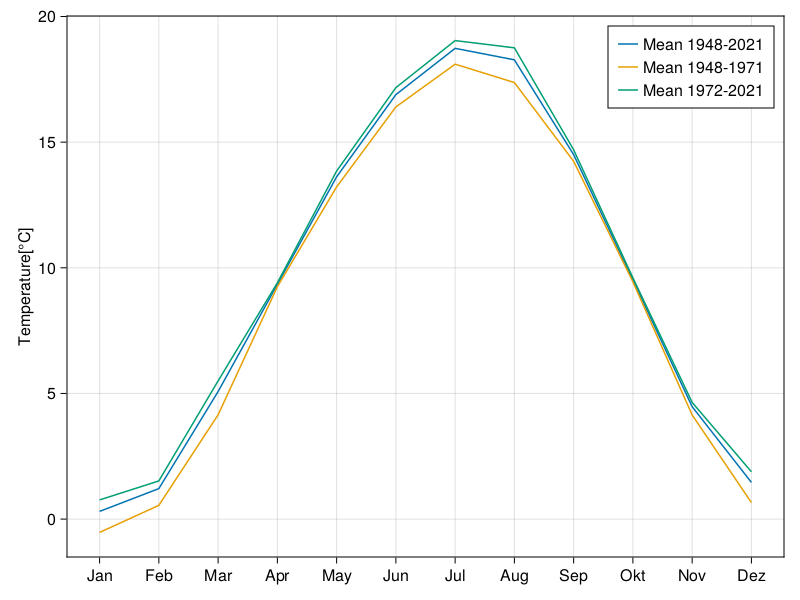

In [18]:
months = split("Jan Feb Mar Apr May Jun Jul Aug Sep Okt Nov Dez")
temp_per_month =  @chain data begin
    groupby(:month) 
    @combine(:avg_temp = mean(:temp),:avg_temp_max = mean(:temp_max),:avg_temp_min = mean(:temp_min),:avg_humi = mean(:humidity))
end

before_1973 = @chain data begin 
    @subset(:year .< 1972)
    groupby(:month)
    @combine(:avg_temp = mean(:temp))
end

after_1973 = @chain data begin 
    @subset(:year .> 1972)
    groupby(:month)
    @combine(:avg_temp = mean(:temp))
end

fig_1 = Figure()
ax1 = Axis(fig_1[1,1], xticks = (1:12, months), ylabel = "Temperature[°C]")
lines!(ax1,temp_per_month.avg_temp, label = "Mean 1948-2021")
lines!(ax1,before_1973.avg_temp, label = "Mean 1948-1971")
lines!(ax1,after_1973.avg_temp, label = "Mean 1972-2021")
axislegend(ax1)
fig_1



### <p style='color: orange'>medium</p>

#### Exercise 6
 Find out what the column "Bedeckung"/"cover/cloudcover" means. Plot its monthly and yearly average since the year it has been measured. Interpret the data to your best ability. 
#### Solution 6

Find the first datapoint since cover has been measured. 

In [42]:
first_cover = data[1,:]
for (i,cover) in enumerate(data.cover)
    if isnan(cover) == false
        first_cover = data[i,:]
        break
    end
end
first_cover
        
    

Row,Zeit,temp_min,temp_max,temp,humidity,rain,preci_type,cover,sun,date,weather,year,month,day,monthday
,String31,Float64,Float64,Float64,Float64,Float64,String7?,Float64,Int64,Date,String31,Int64,Int64,Int64,String
366,1948-12-31T23:00Z,1.9,6.6,3.95,65.38,0.0,missing,6.0,0,1949-01-01,Overcast,1949,1,1,"(1, 1)"


Cover has been measured since 1949. According to [wikipedia](https://de.wikipedia.org/wiki/Bew%C3%B6lkung) cover measures the amount of clouds on the sky in steps from 0-9/8.  

Make a subset of the data starting from 1949 and with measured cover. 

In [47]:
cover_year = @chain data begin 
    @subset(:year .>= 1949, isnan.(:cover) .== false)
    groupby(:year)
    @combine(:cover = mean(:cover))
end

cover_month =  @chain data begin 
    @subset(:year .>= 1949, isnan.(:cover) .== false)
    groupby(:month)
    @combine(:cover = mean(:cover))
end


Row,month,cover
,Int64,Float64
1,1,5.88959
2,2,5.3171
3,3,4.99261
4,4,4.76534
5,5,4.78575
6,6,4.79182
7,7,4.54977
8,8,4.4132
9,9,4.4013


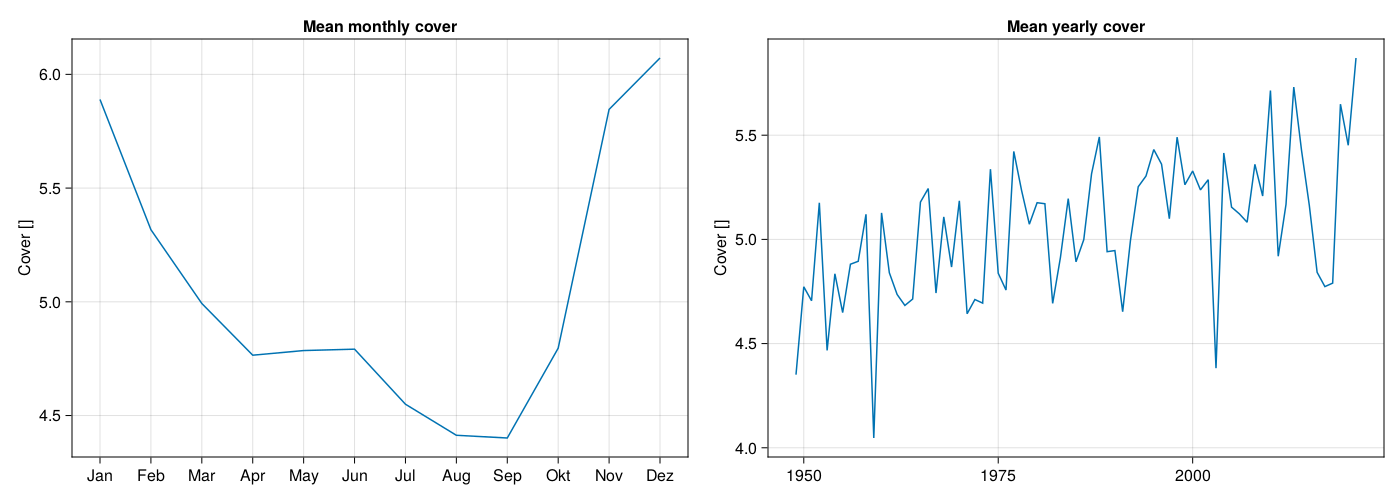

In [57]:
fig_2  = Figure(resolution = (1400,500))
ax2_1 = Axis(fig_2[1,1], title = "Mean monthly cover", xticks = (1:12, months), ylabel = "Cover []")
lines!(ax2_1, cover_month.cover)
ax2_2 = Axis(fig_2[1,2], title = "Mean yearly cover" ,ylabel = "Cover []")
lines!(ax2_2,collect(1949:2021), cover_year.cover)
fig_2

In the summer months are less cloulds on the sky than in the winter months. The yearly mean cover shows a interesting trend, as it increases with time. Maybe climate change is also responsible there ?  

#### Exercise 7
Calculate the standard deviation of the yearly average temperatures (column temp). Is there a significat difference between years ? If so how can we interpret this?  
#### Solution 7

In [58]:
std([2,2,4,6,])

1.9148542155126762

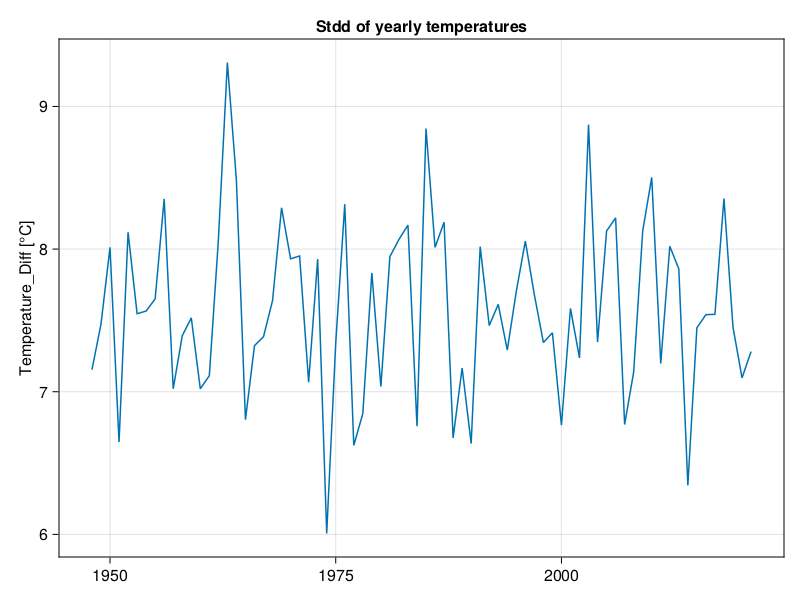

In [61]:
stdd_temp = @chain data begin 
    groupby(:year)
    @combine(:stdd_temp = std(:temp))
end

fig_3  = Figure()
ax3 = Axis(fig_3[1,1], title = "Stdd of yearly temperatures" ,ylabel = "Temperature_Diff [°C]")
lines!(ax3,collect(1948:2021), stdd_temp.stdd_temp)
fig_3

There is a significant variance between the distribution of yearly temperatures from year to year, but there is no clear change over time. 

#### Exercise 8
Split the original dataset (before the filter of the 29th of february) in two datasets using your function definied in exercise 4. One dataset should only contain leap years and the other one should only contain normal years.  
#### Solution 8

In [67]:
# copy and paste import code from above with different names for dataframe
data_2 = DataFrame(CSV.File("dc.csv"))
data_2.Datum = @chain data_2.Datum begin
    # as columns of dataframes are arrays, you need to use the broadcasted `.` version of function which normally only work on scalar types
    replace.("/" => "-") 
    Date.()
end

@chain data_2 begin
    # "Temperatur Min" and "Temerpatur Max" have to be renamed separately as they are Strings and not Symbols due to the space  
    # never use Strings as colums names, as they always cause problems like this
    rename!(:"Temperatur Min" => :temp_min)
    rename!(:"Temperatur Max" => :temp_max)
    rename!(:Luftfeuchtigkeit => :humidity, :Niederschlag => :rain, :Niederschlagsart =>:preci_type, :Temperatur => :temp)
    rename!(:Bedeckung => :cover, :Sonnenscheindauer => :sun, :Datum => :date, :Kategorie => :weather)
end


data_2 = @chain data_2 begin 
    @transform(:year = year.(:date))
    @transform(:month = month.(:date))
    @transform(:day = day.(:date))
    @transform(:monthday = monthday.(:date))
end

data_2.monthday = string.(data_2.monthday)

data_2 = @subset(data_2,:year .!= 2022)

#use own defined function with the . operator to broadcast
leap_years = @subset(data_2, leapyear.(:year) .== true)
normal_years = @subset(data_2, leapyear.(:year) .== false);

#### Exercise 9
Compare the average temperatures per month between leap and normal years and the distribution of temps between all leap years and all non leap years is there a difference  ? 
#### Solution 9

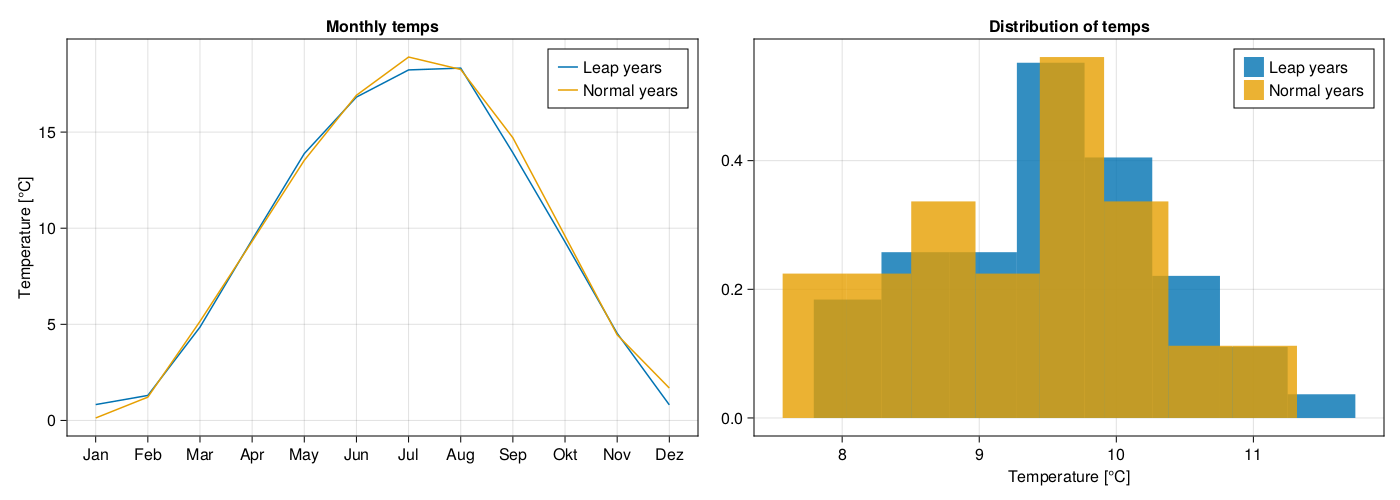

In [81]:
years_leap = @chain leap_years begin 
    groupby(:year)
    @combine(:temp = mean(:temp))
end

years_normal = @chain normal_years begin 
    groupby(:year)
    @combine(:temp = mean(:temp))
end

months_leap = @chain leap_years begin 
    groupby(:month)
    @combine(:temp = mean(:temp))
end

months_normal = @chain normal_years begin 
    groupby(:month)
    @combine(:temp = mean(:temp))
end


fig_4  = Figure(resolution = (1400,500))
ax4_1 = Axis(fig_4[1,1], title = "Monthly temps", xticks = (1:12, months), ylabel = "Temperature [°C]")
lines!(ax4_1,months_leap.temp,label ="Leap years")
lines!(ax4_1,months_normal.temp,label ="Normal years")
axislegend(ax4_1)

ax4_2 = Axis(fig_4[1,2], title = "Distribution of temps" ,xlabel = "Temperature [°C]")
hist!(ax4_2,years_normal.temp, normalization = :pdf,label ="Leap years", bins = 8)
hist!(ax4_2, years_leap.temp, normalization = :pdf, label ="Normal years", bins = 8)
axislegend(ax4_2)

fig_4
    

This simple analysis reveals no significant difference between leap and normal years in their monthly and yearly temperatures. But the sample size is quite small and the noise in the data quite high, which could mask a bias that exists, at least in [theory](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2008GL035209).   